In [5]:
import vk
import time
import pandas as pd

import warnings

warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 1000
from datetime import datetime, date
import seaborn as sns
import numpy as np
from scipy import stats
from collections import Counter
from transliterate import translit
from numpy import mean, std, var

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

import re
import string
from nltk.corpus import stopwords
import nltk
from pymystem3 import Mystem
from string import punctuation
from wordcloud import WordCloud
import ast
from scipy.stats.contingency import margins
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import transformers
import umap
import hdbscan
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import logging

logging.captureWarnings(True)
%load_ext nb_black

<IPython.core.display.Javascript object>

## Data parsing

In [6]:
session = vk.Session(
    access_token="03abb619976b5d747b60c1ee5b44151357bc7875d146e1523281b4468e4cf027d8bdc83f444384a1c3df3"
)

<IPython.core.display.Javascript object>

In [7]:
vk_api = vk.API(session)

<IPython.core.display.Javascript object>

In [ ]:
list_of_groups = vk_api.groups.getById(
    v=5.131,
    group_ids=[
        "rbc",
        "ria",
        "gazeta",
        "tv360",
        "lentaru",
        "kpru",
        "life",
        "m24",
        "snob_project",
        "knife.media",
    ],
    fields="description",
)

In [ ]:
list_of_ids_groups = []
for i in range(len(list_of_groups)):
    list_of_ids_groups.append(list_of_groups[i]["id"])

In [10]:
list_of_ids_groups1 = list_of_ids_groups[:5]
list_of_ids_groups2 = list_of_ids_groups[5:]

<IPython.core.display.Javascript object>

In [11]:
time.sleep(3)
df_escooter_1 = pd.DataFrame()
for i in range(len(list_of_ids_groups1)):
    posts1 = vk_api.wall.search(
        v=5.131,
        owner_id=-list_of_ids_groups1[i],
        query="электросамокат",
        owners_only=1,
        count=100,
    )
    df_1 = pd.json_normalize(posts1["items"])
    df_escooter_1 = pd.concat([df_1, df_escooter_1])

<IPython.core.display.Javascript object>

In [12]:
time.sleep(3)
df_escooter_2 = pd.DataFrame()
for i in range(len(list_of_ids_groups2)):
    posts2 = vk_api.wall.search(
        v=5.131,
        owner_id=-list_of_ids_groups2[i],
        query="электросамокат",
        owners_only=1,
        count=100,
    )
    df_2 = pd.json_normalize(posts2["items"])
    df_escooter_2 = pd.concat([df_2, df_escooter_2])

<IPython.core.display.Javascript object>

In [13]:
time.sleep(3)
df_kicksharing_1 = pd.DataFrame()
for i in range(len(list_of_ids_groups1)):
    posts3 = vk_api.wall.search(
        v=5.131,
        owner_id=-list_of_ids_groups1[i],
        query="кикшеринг",
        owners_only=1,
        count=100,
    )
    df_3 = pd.json_normalize(posts3["items"])
    df_kicksharing_1 = pd.concat([df_3, df_kicksharing_1])

<IPython.core.display.Javascript object>

In [14]:
time.sleep(3)
df_kicksharing_2 = pd.DataFrame()
for i in range(len(list_of_ids_groups2)):
    posts4 = vk_api.wall.search(
        v=5.131,
        owner_id=-list_of_ids_groups2[i],
        query="кикшеринг",
        owners_only=1,
        count=100,
    )
    df_4 = pd.json_normalize(posts4["items"])
    df_kicksharing_2 = pd.concat([df_4, df_kicksharing_2])

<IPython.core.display.Javascript object>

In [15]:
time.sleep(3)
df_rent_1 = pd.DataFrame()
for i in range(len(list_of_ids_groups1)):
    posts5 = vk_api.wall.search(
        v=5.131,
        owner_id=-list_of_ids_groups1[i],
        query="аренда самокат",
        owners_only=1,
        count=100,
    )
    df_5 = pd.json_normalize(posts5["items"])
    df_rent_1 = pd.concat([df_5, df_rent_1])

<IPython.core.display.Javascript object>

In [16]:
time.sleep(3)
df_rent_2 = pd.DataFrame()
for i in range(len(list_of_ids_groups2)):
    posts6 = vk_api.wall.search(
        v=5.131,
        owner_id=-list_of_ids_groups2[i],
        query="аренда самокат",
        owners_only=1,
        count=100,
    )
    df_6 = pd.json_normalize(posts6["items"])
    df_rent_2 = pd.concat([df_6, df_rent_2])

<IPython.core.display.Javascript object>

In [17]:
df_rent_1["query"] = "аренда самокат"
df_rent_2["query"] = "аренда самокат"
df_kicksharing_1["query"] = "кикшеринг"
df_kicksharing_2["query"] = "кикшеринг"
df_escooter_1["query"] = "электросамокат"
df_escooter_2["query"] = "электросамокат"

<IPython.core.display.Javascript object>

In [18]:
df_posts = pd.concat(
    [
        df_rent_1,
        df_rent_2,
        df_kicksharing_1,
        df_kicksharing_2,
        df_escooter_1,
        df_escooter_2,
    ]
)

<IPython.core.display.Javascript object>

In [19]:
df_posts = df_posts.drop_duplicates(subset="id")

<IPython.core.display.Javascript object>

In [20]:
df_posts.to_csv('df_posts.csv', index=False)

<IPython.core.display.Javascript object>

In [ ]:
list_of_id_lists = []
for i in range(len(list(df_posts.owner_id.unique()))):
    list_of_id_lists.append(
        list(
            df_posts[df_posts["owner_id"] == list(df_posts.owner_id.unique())[i]]["id"]
        )
    )

In [ ]:
list_of_owner_ids = list(df_posts.owner_id.unique())

In [ ]:
df1 = pd.DataFrame()
df3 = pd.DataFrame()
for i in range(len(list_of_owner_ids)):
    for j in range(len(list_of_id_lists[i])):
        time.sleep(3)
        get_comments = vk_api.wall.getComments(v=5.131,
                                      owner_id = list_of_owner_ids[i],
                                      post_id = list_of_id_lists[i][j],
                                      need_likes = 1,
                                      count = 100,
                                      preview_length = 0,
                                      extended = 1,
                                      thread_items_count = 10,
                                      fields = ['bdate', 'city', 'home_town'])
        df2 = pd.json_normalize(get_comments["items"])
        df4 = pd.json_normalize(get_comments["profiles"])
        df1 = pd.concat([df1, df2])
        df3 = pd.concat([df3, df4])

In [ ]:
df1.to_csv('comments.csv', index=False)

In [ ]:
df3.to_csv('people.csv', index=False)

In [ ]:
comments = pd.read_csv('comments.csv')

In [ ]:
df_threads = pd.DataFrame()
for i in comments['thread.items'].index:
    thread = ast.literal_eval(comments['thread.items'][i])
    df_thred = pd.json_normalize(thread)
    df_threads = pd.concat([df_thred, df_threads])

In [ ]:
df_threads = df_threads.reset_index(drop=True)

In [ ]:
df_threads = df_threads[1770:]

In [ ]:
df_threads = df_threads.reset_index(drop=True)

In [ ]:
df_threads = df_threads[802:]
df_threads = df_threads.reset_index(drop=True)

In [23]:
df_threads.to_csv('df_threads.csv', index=False)

<IPython.core.display.Javascript object>

In [ ]:
df_threads_ = pd.DataFrame()
for i in range(len(df_threads["id"])):
    time.sleep(3)
    get_comments = vk_api.wall.getComment(
        v=5.131,
        owner_id=df_threads["owner_id"][i],
        comment_id=df_threads["id"][i],
        extended=1,
        fields=["bdate", "city", "home_town"],
    )
    df_threads_1 = pd.json_normalize(get_comments["profiles"])
    df_threads_ = pd.concat([df_threads_, df_threads_1])

In [25]:
df_threads_.to_csv('people_threads_part3.csv', index=False)
df_threads_.to_csv('people_threads_part2.csv', index=False)
df_threads_.to_csv('people_threads_part2.csv', index=False)

<IPython.core.display.Javascript object>

In [28]:
posts = pd.read_csv("df_posts.csv")
comments = pd.read_csv("comments.csv")
people = pd.read_csv("people.csv")
threads = pd.read_csv("df_threads.csv")
people_threads = pd.read_csv("df_threads.csv")

<IPython.core.display.Javascript object>

In [27]:
for i in [posts, comments, people, threads, people_threads]:
    print(i.shape)

(311, 27)
(5434, 20)
(6668, 10)
(4830, 14)
(4830, 14)


<IPython.core.display.Javascript object>

## Describe a social portrait of people commenting on kicksharing posts in VK publics

In [29]:
# concatenating information about the main commentators + commentators from the thread
all_people = pd.concat([people, people_threads])
all_people = all_people[~all_people.last_name.isna()]
all_people.drop_duplicates(inplace=True)
# remove deleted and blocked users
all_people = all_people[~all_people.deactivated.isin(["banned", "deleted"])]
# there are several problems with age – missing data and the absence of a year in the data
# let's take the minimum age value in terms of the number of characters and filter out those who have age data
all_people_with_age = all_people[
    all_people.bdate.apply(lambda x: len(str(x))) >= len("7.1.1985")
]
#  find those who have no age or it is without a year
all_people_without_age = all_people[
    all_people.bdate.apply(lambda x: len(str(x))) < len("7.1.1985")
]

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'Возраст, в годах')]

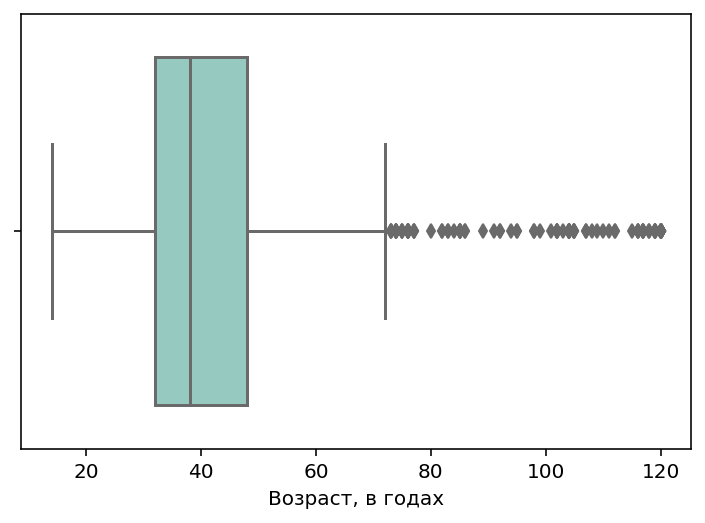

<IPython.core.display.Javascript object>

In [30]:
age_list = list(all_people_with_age.bdate)
# Since the age format is str, it needs to be converted to datetime.
for i in range(len(age_list)):
    if (age_list[i].find(".") == 1) & (
        age_list[i].find(".", age_list[i].find(".") + 1) == 3
    ):
        age_list[i] = "0" + age_list[i]
        age_list[i] = age_list[i][:3] + "0" + age_list[i][3:]

    if (age_list[i].find(".") == 1) & (
        age_list[i].find(".", age_list[i].find(".") + 1) == 4
    ):
        age_list[i] = "0" + age_list[i]

    if (age_list[i].find(".") == 2) & (
        (age_list[i].find(".", age_list[i].find(".") + 1)) == 4
    ):
        age_list[i] = age_list[i][:3] + "0" + age_list[i][3:]

    if (age_list[i].find(".") == 1) & (
        age_list[i].find(".", age_list[i].find(".") + 1) == 4
    ):
        age_list[i] = "0" + age_list[i]

all_people_with_age.insert(loc=1, column="age", value=age_list)

all_people_with_age["age_len"] = all_people_with_age.age.apply(lambda x: len(str(x)))
all_people_with_age.age = all_people_with_age.age.apply(
    lambda x: datetime.strptime(x, "%d.%m.%Y")
)


def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))


all_people_with_age["age_years"] = all_people_with_age.age.apply(
    lambda x: calculate_age(x)
)
all_people_with_age = all_people_with_age.reset_index(drop=True)
sns.boxplot(all_people_with_age["age_years"], palette="Set3").set(
    xlabel="Возраст, в годах"
)

In [31]:
# The graph shows that there are outliers in the data.
# Let's apply the z-criteria in order to identify the index of people with an outlier age.
z = np.abs(stats.zscore(all_people_with_age["age_years"]))
threshold = 3
outliers_age = list((np.where(z > 3))[0])

# Let's remove outliers from the data and calculate the median
all_people_with_age_without_outliers = all_people_with_age[
    ~all_people_with_age.index.isin(outliers_age)
]
print(f"Median age is {all_people_with_age_without_outliers.age_years.median()}")

Median age is 38.0


<IPython.core.display.Javascript object>

In [32]:
# Replace the age of people with the age-outlier by the median and calculate the median for all people with age
all_people_with_age.loc[
    outliers_age, "age_years"
] = all_people_with_age_without_outliers.age_years.median()
print(f"Median age for people with age is {all_people_with_age.age_years.median()}")

Median age for people with age is 38.0


<IPython.core.display.Javascript object>

In [8]:
print(all_people_with_age.age_years.describe())

count    2102.000000
mean       39.812084
std        13.608603
min        14.000000
25%        32.000000
50%        38.000000
75%        46.750000
max        95.000000
Name: age_years, dtype: float64


<IPython.core.display.Javascript object>

In [33]:
# get the final dataset with the correct age for all users
all_people_without_age["age_years"] = all_people_with_age.age_years.median()
all_people_clear_age = pd.concat([all_people_without_age, all_people_with_age])
all_people_clear_age.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

In [34]:
# Let's determine the gender of a person using a database of fake names and gender.
# We will also add names and surnames translated to the dataset.
dfru = pd.read_csv("FakeNameGenerator.com_de68fd01.csv")
list_of_translit_names = []
for i in dfru.GivenName.index:
    list_of_translit_names.append(
        translit(dfru.GivenName[i], language_code="ru", reversed=True)
    )

list_of_translit_surnames = []
for i in dfru.Surname.index:
    list_of_translit_surnames.append(
        translit(dfru.Surname[i], language_code="ru", reversed=True)
    )

df_of_translit_names = pd.DataFrame(list_of_translit_names)
df_of_translit_surnames = pd.DataFrame(list_of_translit_surnames)

df_of_translit_names = df_of_translit_names.rename(columns={0: "GivenName"})
df_of_translit_surnames = df_of_translit_surnames.rename(columns={0: "Surname"})

df_translit = pd.concat([df_of_translit_names, df_of_translit_surnames], axis=1)
df_translit = pd.concat([df_translit, dfru["Gender"]], axis=1)

dfru = pd.concat([dfru, df_translit])
dfru = dfru.reset_index(drop=True)

# Let's also take an additional dataset and add a translit to it

df2 = pd.read_csv("russian_names.csv", sep=";")

dict1 = {"Ж": "female", "М": "male"}
df2["Gender"] = df2.Sex.apply(lambda x: dict1[x])

df2 = df2[["Name", "Gender"]]
df2 = df2.rename(columns={"Name": "GivenName"})

list_of_translit_names2 = []
for i in df2.GivenName.index:
    list_of_translit_names2.append(
        translit(df2.GivenName[i], language_code="ru", reversed=True)
    )
df_of_translit_names2 = pd.DataFrame(list_of_translit_names2)
df_of_translit_names2 = df_of_translit_names2.rename(columns={0: "GivenName"})
df_translit2 = pd.concat([df_of_translit_names2, df2["Gender"]], axis=1)

df2 = pd.concat([df2, df_translit2])
df2 = df2.reset_index(drop=True)

dfru = pd.concat([dfru, df2])

# Let's also take a dataset with foreign names

df3 = pd.read_csv("foreign_names.csv", sep=";")

df3 = df3[["name", "gender"]]
df3 = df3.rename(columns={"name": "GivenName", "gender": "Gender"})

dfru = pd.concat([dfru, df3])
dfru.Surname = dfru.Surname.fillna("x")
dfru.Gender = dfru.Gender.apply(lambda x: x.lower())

# Let's create words with female and male names and the endings of surnames

rumalenames = set(dfru[dfru["Gender"] == "male"]["GivenName"])
rumalesurnames = set(s[-3:] for s in dfru[dfru["Gender"] == "male"]["Surname"])

rufemalenames = set(dfru[dfru["Gender"] == "female"]["GivenName"])
rufemalesurnames = set(s[-3:] for s in dfru[dfru["Gender"] == "female"]["Surname"])

# Let's determine the gender of a person
list_gender = []

for i in all_people_clear_age.index:
    name = all_people_clear_age["first_name"][i]
    surname = all_people_clear_age["last_name"][i]
    if (name in rumalenames) or (surname in rumalesurnames):
        list_gender.append("m")
    elif (name in rufemalenames) or (surname in rufemalesurnames):
        list_gender.append("f")
    else:
        list_gender.append("unk")

Counter(list_gender)

Counter({'f': 1261, 'm': 3102, 'unk': 346})

<IPython.core.display.Javascript object>

In [35]:
# Let's add a column with the gender to the dataset, and also try to check the surnames in the name and vice versa
df_g = pd.DataFrame(list_gender)
df_g = df_g.rename(columns={0: "gen"})
all_people_clear_age_gen0 = pd.concat([all_people_clear_age, df_g], axis=1)
all_people_clear_age_gen0_unk = all_people_clear_age_gen0[
    all_people_clear_age_gen0.gen == "unk"
]
all_people_clear_age_gen0_unk = all_people_clear_age_gen0_unk.drop(
    all_people_clear_age_gen0_unk.columns[26], axis=1
)
all_people_clear_age_gen0_unk = all_people_clear_age_gen0_unk.reset_index(drop=True)

list_gender2 = []

for i in all_people_clear_age_gen0_unk.index:
    name = all_people_clear_age_gen0_unk["first_name"][i]
    surname = all_people_clear_age_gen0_unk["last_name"][i]
    if (surname in rumalenames) or (name in rumalesurnames):
        list_gender2.append("m")
    elif (surname in rufemalenames) or (name in rufemalesurnames):
        list_gender2.append("f")
    else:
        list_gender2.append("unk")

Counter(list_gender2)

Counter({'unk': 295, 'm': 35, 'f': 16})

<IPython.core.display.Javascript object>

In [36]:
# Since unk is only about 6% of the gender of all users, we will calculate and replace them with mode
df_g2 = pd.DataFrame(list_gender2)
df_g2 = df_g2.rename(columns={0: "gen"})
all_people_clear_age_gen1 = pd.concat([all_people_clear_age_gen0_unk, df_g2], axis=1)
all_people_clear_age_gen0_not_unk = all_people_clear_age_gen0[
    all_people_clear_age_gen0.gen != "unk"
]
df_age_middle = pd.concat(
    [all_people_clear_age_gen0_not_unk, all_people_clear_age_gen1]
)
print(f"Mode of gender is {df_age_middle.gen.mode()[0]} (man)")

Mode of gender is m (man)


<IPython.core.display.Javascript object>

In [37]:
dict3 = {"unk": "m", "m": "m", "f": "f"}
df_age_middle["gen"] = df_age_middle["gen"].apply(lambda x: dict3[x])
print(df_age_middle["gen"].value_counts())

m    3432
f    1277
Name: gen, dtype: int64


<IPython.core.display.Javascript object>

In [38]:
# Let's look at the distribution by city
print(df_age_middle["city.title"].isna().value_counts())

False    3347
True     1362
Name: city.title, dtype: int64


<IPython.core.display.Javascript object>

In [39]:
df_age_middle["home_town"].isna().value_counts()

True     3939
False     770
Name: home_town, dtype: int64

<IPython.core.display.Javascript object>

In [40]:
df_age_middle["city"] = df_age_middle["city.title"].fillna(df_age_middle["home_town"])
df_age_middle["city"].isna().value_counts()

False    3477
True     1232
Name: city, dtype: int64

<IPython.core.display.Javascript object>

In [41]:
df_age_middle["city"] = df_age_middle["city"].apply(lambda x: str(x).lower())
print(f'Mode of the city is {df_age_middle["city"].mode()[0]}')

Mode of the city is москва


<IPython.core.display.Javascript object>

In [42]:
df_age_middle = df_age_middle.reset_index(drop=True)
df_city_nan = df_age_middle[df_age_middle.city == "nan"]
df_city_ = df_age_middle[df_age_middle.city != "nan"]
dict4 = {"nan": "москва"}
df_city_nan["city"] = df_city_nan["city"].apply(lambda x: dict4[x])
people_final = pd.concat([df_city_nan, df_city_])
people_final.to_csv("people_final.csv", index=False)

<IPython.core.display.Javascript object>

In [43]:
people_final = people_final[
    [
        "id",
        "first_name",
        "last_name",
        "can_access_closed",
        "bdate",
        "city.title",
        "home_town",
        "age_years",
        "gen",
        "city",
    ]
]

people_final["gen"].unique()

dict5 = {"f": "Женский", "m": "Мужской"}
people_final["gen"] = people_final["gen"].apply(lambda x: dict5[x])

<IPython.core.display.Javascript object>

### Gender distribution

In [44]:
people_final["gen"].value_counts()

Мужской    3432
Женский    1277
Name: gen, dtype: int64

<IPython.core.display.Javascript object>

In [45]:
people_final["gen"].value_counts(normalize=True)

Мужской    0.728817
Женский    0.271183
Name: gen, dtype: float64

<IPython.core.display.Javascript object>

*Since the gender variable is measured on a nominal scale, mode is used as a measure of the central trend, and the spread measure is the coefficient of qualitative variation.*

In [46]:
people_final["gen"].mode()

0    Мужской
Name: gen, dtype: object

<IPython.core.display.Javascript object>

In [47]:
dict6 = {"Женский": 1, "Мужской": 0}
people_final["gen_binary"] = people_final["gen"].apply(lambda x: dict6[x])

<IPython.core.display.Javascript object>

In [48]:
people_final["gen_binary"].value_counts()

0    3432
1    1277
Name: gen_binary, dtype: int64

<IPython.core.display.Javascript object>

In [49]:
n = 4709
k = 2
n1 = people_final["gen_binary"].value_counts()[0]
n2 = people_final["gen_binary"].value_counts()[1]

<IPython.core.display.Javascript object>

In [50]:
print(
    f"The coefficient of qualitative variation is {((2 * k) / (n ** 2 * (k - 1))) * n1 * n2}"
)

The coefficient of qualitative variation is 0.7905708316615694


<IPython.core.display.Javascript object>

*So, the coefficient of qualitative variation is 0.79. Thus, since the the coefficient of qualitative variation is close enough to 1, it means that from the point of view of the distribution by gender, the data are heterogeneous.*

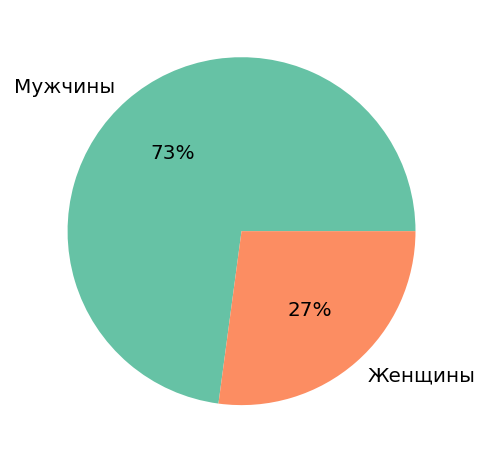

<IPython.core.display.Javascript object>

In [51]:
data = list(people_final["gen_binary"].value_counts())
labels = ["Мужчины", "Женщины"]
colors = sns.color_palette("Set2")[0:5]
plt.pie(data, labels=labels, colors=colors, autopct="%.0f%%")
plt.show()

### Age distribution

In [55]:
people_final["age_years"] = people_final["age_years"].apply(lambda x: int(x))

<IPython.core.display.Javascript object>

In [63]:
mean = people_final["age_years"].mean()
print(f"Mean age is {mean}")

Mean age is 38.808876619239754


<IPython.core.display.Javascript object>

In [64]:
median = people_final["age_years"].median()
print(f"Median age is {median}")

Median age is 38.0


<IPython.core.display.Javascript object>

In [66]:
mode = people_final["age_years"].mode()
print(f"Mode age is {mode[0]}")

Mode age is 38


<IPython.core.display.Javascript object>

In [67]:
print(f'Variance is {var(people_final["age_years"])}')

Variance is 83.43894435279643


<IPython.core.display.Javascript object>

In [68]:
print(f'Standart deviation is {std(people_final["age_years"])}')

Standart deviation is 9.134492013943436


<IPython.core.display.Javascript object>

Therefore, the average age of users is within 38 +- 9.1 * 3

In [69]:
RQ = people_final["age_years"].describe()[6] - people_final["age_years"].describe()[4]
RQ

0.0

<IPython.core.display.Javascript object>

*RQ is 0, the age data is homogeneous*

In [70]:
std(people_final["age_years"]) / people_final["age_years"].mean()

0.2353712039532459

<IPython.core.display.Javascript object>

*Since the coefficient of variation does not exceed 30-35%, the age data are highly homogeneous.*

[Text(0.5, 0, 'Возраст, в годах')]

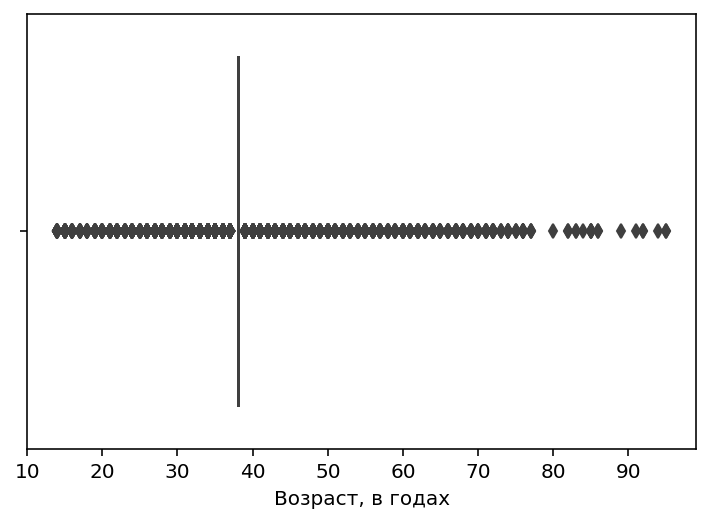

<IPython.core.display.Javascript object>

In [71]:
sns.boxplot(people_final["age_years"]).set(xlabel="Возраст, в годах")

In [72]:
# Let's look at the statistics on data in which omissions and dates of birth were removed without specifying the year

<IPython.core.display.Javascript object>

In [73]:
all_people_with_age["age_years"] = all_people_with_age["age_years"].apply(
    lambda x: int(x)
)

<IPython.core.display.Javascript object>

In [76]:
mean2 = all_people_with_age["age_years"].mean()
print(f"Mean age is {mean2}")

Mean age is 39.81208372978116


<IPython.core.display.Javascript object>

In [77]:
median2 = all_people_with_age["age_years"].median()
print(f"Median age is {median2}")

Mean age is 38.0


<IPython.core.display.Javascript object>

In [82]:
mode2 = all_people_with_age["age_years"].mode()
print(f"Mode age is {mode2[0]}")

Mode age is 38


<IPython.core.display.Javascript object>

In [79]:
print(f'Variance is {var(all_people_with_age["age_years"])}')

Variance is 185.10598148109577


<IPython.core.display.Javascript object>

In [83]:
print(f'Standart deviation is {std(all_people_with_age["age_years"])}')

Standart deviation is 13.60536590765187


<IPython.core.display.Javascript object>

*Therefore, the average age of users is within 40 +- 13.6 * 3*

In [84]:
RQ = (
    all_people_with_age["age_years"].describe()[6]
    - all_people_with_age["age_years"].describe()[4]
)
RQ  

14.75

<IPython.core.display.Javascript object>

In [85]:
std(all_people_with_age["age_years"]) / all_people_with_age["age_years"].mean()

0.3417396085067124

<IPython.core.display.Javascript object>

*Since the coefficient of variation does not exceed 30-35%, the age data still have a high uniformity.*

[Text(0.5, 0, 'Возраст, в годах')]

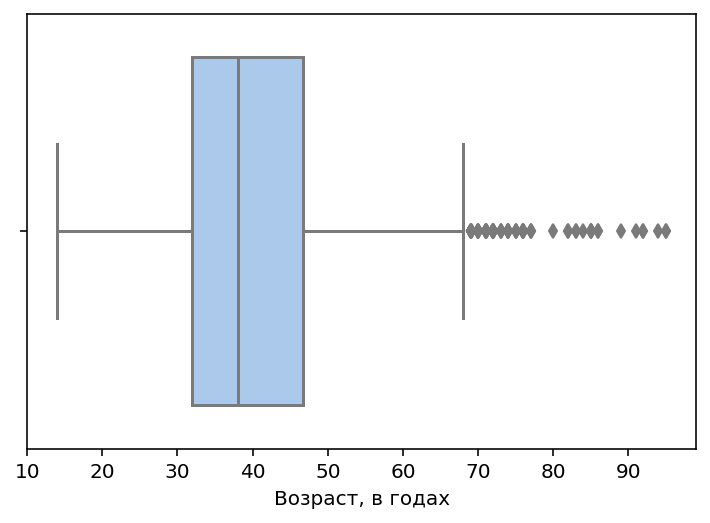

<IPython.core.display.Javascript object>

In [86]:
sns.boxplot(all_people_with_age["age_years"], palette="pastel").set(
    xlabel="Возраст, в годах"
)

### City distribution

In [87]:
pd.DataFrame(people_final["city"].value_counts(normalize=True).head(10))

,city
москва,0.543640
санкт-петербург,0.078148
екатеринбург,0.009344
казань,0.009131
самара,0.007857
новосибирск,0.007645
нижний новгород,0.006583
челябинск,0.006158
воронеж,0.006158
краснодар,0.005946


<IPython.core.display.Javascript object>

*Since the city variable is measured on a nominal scale, mode is used as a measure of the central trend, and the spread measure is the coefficient of qualitative variation.*

In [89]:
mode_city = people_final["city"].mode()[0]
print(f'Mode of the city is "{mode_city}"')

Mode of the city is "москва"


<IPython.core.display.Javascript object>

In [90]:
# the coefficient of qualitative variation
n = 4709
k = 617
numerator = (2 * k) / (n ** 2 * (k - 1))

<IPython.core.display.Javascript object>

In [91]:
city_list = list(np.array(people_final["city"].value_counts()))
reverse_list = city_list[::-1]
denominator = np.dot(city_list[:616][::-1], list(np.cumsum(reverse_list))[:616])

<IPython.core.display.Javascript object>

In [92]:
numerator * denominator

0.6985129669974719

<IPython.core.display.Javascript object>

**So, the coefficient of qualitative variationis 0.69. Thus, since the the coefficient of qualitative variation is close enough to 1, it means that from the point of view of the distribution by city, the data are heterogeneous.*

In [93]:
# It is obvious that the distribution is heterogeneous due to filling in the gaps with a mode with the value "Moscow"
# Let's look at the statistics on the data in which the omissions were removed

<IPython.core.display.Javascript object>

In [96]:
pd.DataFrame(df_city_["city"].value_counts(normalize=True).head(10))

,city
москва,0.381938
санкт-петербург,0.105838
екатеринбург,0.012655
казань,0.012367
самара,0.010641
новосибирск,0.010354
нижний новгород,0.008916
челябинск,0.008341
воронеж,0.008341
краснодар,0.008053


<IPython.core.display.Javascript object>

In [97]:
mode_city = df_city_["city"].mode()[0]
print(f'Mode is "{mode_city}"')

Mode is "москва"


<IPython.core.display.Javascript object>

In [98]:
# the coefficient of qualitative variation
n2 = 3477
k2 = 617
numerator2 = (2 * k2) / (n2 ** 2 * (k2 - 1))

<IPython.core.display.Javascript object>

In [99]:
city_list2 = list(np.array(df_city_["city"].value_counts()))
reverse_list2 = city_list2[::-1]
denominator2 = np.dot(city_list2[:616][::-1], list(np.cumsum(reverse_list2))[:616])

<IPython.core.display.Javascript object>

In [100]:
numerator2 * denominator2

0.8425117485993431

<IPython.core.display.Javascript object>

So, the coefficient of qualitative variation is 0.84. Thus, since the coefficient of qualitative variation is close enough to 1, it means that from the point of view of gender distribution, the data became even more heterogeneous after the omissions were removed.

## Identify the most popular terms used in the discussion of the topic of kicksharing

In [83]:
threads = threads.dropna(subset="text")


def comment_without_id(x):
    try:
        return x.split("],")[1]
    except:
        return x.split("],")[0]


threads.text = threads.text.apply(lambda x: comment_without_id(x))

threads = threads.dropna(subset="text")
threads = threads[threads.text != ""]

all_comments = pd.concat([comments, threads]).dropna(subset="text")
all_comments.text = all_comments.text.apply(lambda x: x.lower()).apply(
    lambda x: re.sub(r"\d+", "", x)
)
all_comments = all_comments.reset_index(drop=True)
all_comments["text_for_sentiment"] = (
    all_comments.text.apply(
        lambda x: x.translate(str.maketrans("", "", string.punctuation))
    )
    .apply(lambda x: x.strip().replace("\r\n", "\n").replace("\r", "\n"))
    .apply(lambda x: re.sub(r"\n", "", x))
)

mystem = Mystem()
russian_stopwords = stopwords.words("russian") + [
    "это",
    "хотеть",
    "делать",
    "начинать",
    "хотеться",
    "мочь",
    "который",
    "весь",
    "свой",
]


def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [
        token
        for token in tokens
        if token not in russian_stopwords
        and token != " "
        and token.strip() not in punctuation
        and token not in russian_stopwords
    ]

    text = " ".join(tokens)

    return text


def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)


all_comments.text = all_comments.text.apply(lambda x: preprocess_text(remove_emoji(x)))
all_comments = (
    all_comments[all_comments.text != ""].dropna(subset="text").reset_index(drop=True)
)
all_comments["text"] = all_comments["text"].apply(lambda x: str(x))
clean = all_comments["text"].values

<IPython.core.display.Javascript object>

In [84]:
np.savetxt("text.txt", all_comments["text"].values, delimiter=" ", fmt="%s")

with open("clean_data.txt", "w") as output:
    output.write(str(clean)[2:-2])

with open("text.txt", "r", encoding="utf-8") as f:
    stop_words = f.read().split()

with open("text.txt", "r", encoding="utf-8") as f:
    words = f.read().split()

<IPython.core.display.Javascript object>

In [85]:
words = [word.replace("'", "") for word in words]
words = list(filter(lambda x: x != "»", words))
words = list(filter(lambda x: x != "«", words))
data = Counter(words)

<IPython.core.display.Javascript object>

In [86]:
background_color = "#101010"
height = 720
width = 1080

word_cloud = WordCloud(background_color=background_color, width=width, height=height)

word_cloud.generate_from_frequencies(data)

word_cloud.to_file("image_11.png")

<IPython.core.display.Javascript object>

In [87]:
all_comments.to_csv("data_before_.csv", index=False)

<IPython.core.display.Javascript object>

## To determine the sentiment of messages about the kicksharing

In [88]:
data = pd.read_csv("data_before_.csv")
data.shape

(9722, 21)

<IPython.core.display.Javascript object>

In [89]:
model_checkpoint = "blanchefort/rubert-base-cased-sentiment"
classifier = pipeline("sentiment-analysis", model=model_checkpoint)

<IPython.core.display.Javascript object>

In [90]:
data = data[data.text_for_sentiment.apply(lambda x: len(str(x))) < 512]
data.shape

(9629, 21)

<IPython.core.display.Javascript object>

In [64]:
data['sentiment_analysis_value'] = data['text_for_sentiment'].apply(lambda x: classifier(x)[0]['label'])
data['sentiment_analysis_score'] = data['text_for_sentiment'].apply(lambda x: classifier(x)[0]['score'])
data.to_csv('data_with_sentiment.csv', index=False)

<IPython.core.display.Javascript object>

In [91]:
data = pd.read_csv("data_with_sentiment.csv")
print(data.sentiment_analysis_value.value_counts())

NEUTRAL     4503
NEGATIVE    4166
POSITIVE     950
Name: sentiment_analysis_value, dtype: int64


<IPython.core.display.Javascript object>

## To identify whether the sentiment of the messages about the phenomenon depends on the tone of the news publication

In [92]:
missing_posts = posts[posts.text.isna()]
missing_posts = missing_posts.dropna(subset="copy_history")

<IPython.core.display.Javascript object>

In [93]:
df_missing_posts = pd.DataFrame()
for i in missing_posts["copy_history"].index:
    miss_post = ast.literal_eval(missing_posts["copy_history"][i])
    df_miss_post = pd.json_normalize(miss_post)
    df_missing_posts = pd.concat([df_miss_post, df_missing_posts])

<IPython.core.display.Javascript object>

In [94]:
df_missing_posts = df_missing_posts.set_index(missing_posts.index)

<IPython.core.display.Javascript object>

In [95]:
for i in missing_posts.index:
    posts.text[i] = df_missing_posts.text[i]

<IPython.core.display.Javascript object>

In [96]:
posts = posts.dropna(subset="text")

<IPython.core.display.Javascript object>

In [97]:
posts = posts.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [98]:
posts.text = posts.text.apply(lambda x: x.lower())
posts.text = posts.text.apply(lambda x: re.sub(r"\d+", "", x))
posts = posts.reset_index(drop=True)
posts.text = posts.text.apply(
    lambda x: x.translate(str.maketrans("", "", string.punctuation))
)
posts.text = posts.text.apply(
    lambda x: x.strip().replace("\r\n", "\n").replace("\r", "\n")
)
posts.text = posts.text.apply(lambda x: re.sub(r"\n", "", x))
posts.text = posts.text.apply(lambda x: re.sub(r"\n", "", x))
posts["text_for_sentiment"] = posts.text

<IPython.core.display.Javascript object>

In [76]:
posts.to_csv('posts_for_sentiment.csv', index=False)

<IPython.core.display.Javascript object>

In [99]:
posts = pd.read_csv("posts_for_sentiment.csv")

<IPython.core.display.Javascript object>

In [100]:
posts["len_of_post"] = posts["text_for_sentiment"].apply(lambda x: len(x))

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'Длина новостной публикации'), Text(0, 0.5, 'Количество постов')]

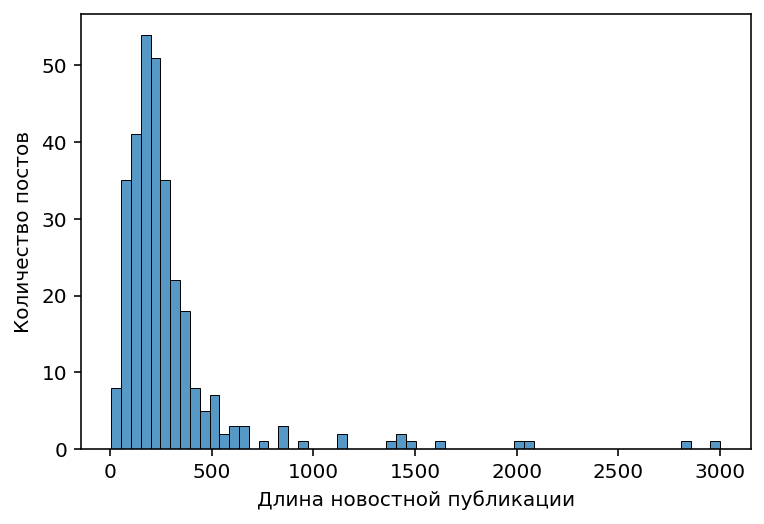

<IPython.core.display.Javascript object>

In [101]:
sns.histplot(data=posts, x=posts["len_of_post"]).set(
    xlabel="Длина новостной публикации", ylabel="Количество постов"
)

In [102]:
print(f'Median length of post {posts["len_of_post"].median()}')

Median length of post 211.5


<IPython.core.display.Javascript object>

In [103]:
print(
    f'Percentage of posts with length less that 512 is {posts[posts["len_of_post"] < 512].shape[0] / posts.shape[0]}'
)

Percentage of posts with length less that 512 is 0.9090909090909091


<IPython.core.display.Javascript object>

In [104]:
posts = posts[posts.text_for_sentiment.apply(lambda x: len(x)) < 512]
posts['sentiment_analysis_value'] = posts['text_for_sentiment'].apply(lambda x: classifier(x)[0]['label'])
posts['sentiment_analysis_score'] = posts['text_for_sentiment'].apply(lambda x: classifier(x)[0]['score'])
posts.to_csv('posts_with_sentiment.csv', index=False)

<IPython.core.display.Javascript object>

In [105]:
posts = pd.read_csv("posts_with_sentiment.csv")

<IPython.core.display.Javascript object>

In [106]:
posts = posts.rename(
    columns={
        "sentiment_analysis_value": "sentiment_analysis_value_post",
        "sentiment_analysis_score": "sentiment_analysis_score_post",
    }
)

<IPython.core.display.Javascript object>

In [107]:
print(posts.sentiment_analysis_value_post.value_counts())

NEUTRAL     160
NEGATIVE     77
POSITIVE     43
Name: sentiment_analysis_value_post, dtype: int64


<IPython.core.display.Javascript object>

In [108]:
posts_with_sentiment_for_chi_square = posts[
    ["id", "sentiment_analysis_value_post", "sentiment_analysis_score_post"]
]
posts_with_sentiment_for_chi_square_fot_dict = posts_with_sentiment_for_chi_square.set_index(
    "id"
)
dict_posts = posts_with_sentiment_for_chi_square_fot_dict[
    "sentiment_analysis_value_post"
].to_dict()
dict_posts_score = posts_with_sentiment_for_chi_square_fot_dict[
    "sentiment_analysis_score_post"
].to_dict()

<IPython.core.display.Javascript object>

In [109]:
data2 = data[
    data["post_id"].isin(posts_with_sentiment_for_chi_square.id.unique())
].reset_index(drop=True)
data2.post_id = data2.post_id.apply(lambda x: int(x))

<IPython.core.display.Javascript object>

In [110]:
data = pd.read_csv("data_with_sentiment.csv")
data2["sentiment_post_value"] = data2.post_id.apply(lambda x: dict_posts[x])
data2["sentiment_post_score"] = data2.post_id.apply(lambda x: dict_posts_score[x])
crosstab1 = pd.crosstab(
    data2["sentiment_post_value"], data2["sentiment_analysis_value"]
)

<IPython.core.display.Javascript object>

In [111]:
crosstab1

sentiment_analysis_value,NEGATIVE,NEUTRAL,POSITIVE
sentiment_post_value,,,
NEGATIVE,1553,1569,320
NEUTRAL,1974,2213,473
POSITIVE,515,567,133


<IPython.core.display.Javascript object>

In [112]:
stats.chi2_contingency(crosstab1)

(8.209802163509796,
 0.0841882423474345,
 4,
 array([[1493.24503596, 1606.6607277 ,  342.09423634],
        [2021.65074595, 2175.20017173,  463.14908232],
        [ 527.1042181 ,  567.13910057,  120.75668134]]))

<IPython.core.display.Javascript object>

In [113]:
data2_without_neutral = data2[
    (data2["sentiment_post_value"] != "NEUTRAL")
    & (data2["sentiment_analysis_value"] != "NEUTRAL")
]

<IPython.core.display.Javascript object>

In [114]:
crosstab_without_neutral = pd.crosstab(
    data2_without_neutral["sentiment_post_value"],
    data2_without_neutral["sentiment_analysis_value"],
)
crosstab_without_neutral

sentiment_analysis_value,NEGATIVE,POSITIVE
sentiment_post_value,,
NEGATIVE,1553,320
POSITIVE,515,133


<IPython.core.display.Javascript object>

In [115]:
stats.chi2_contingency(crosstab_without_neutral)

(3.6347513040114254,
 0.05658505790480893,
 1,
 array([[1536.43950813,  336.56049187],
        [ 531.56049187,  116.43950813]]))

<IPython.core.display.Javascript object>

## To identify which factors contribute to the formation of opinions about kicksharing

In [116]:
data = pd.read_csv("data_with_sentiment.csv")

<IPython.core.display.Javascript object>

In [117]:
sentences = list(data.text_for_sentiment)
sentences_test1 = sentences[0:2000]
sentences_test2 = sentences[2000:4000]
sentences_test3 = sentences[4000:6000]
sentences_test4 = sentences[6000:8000]
sentences_test5 = sentences[8000:]

<IPython.core.display.Javascript object>

In [119]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

<IPython.core.display.Javascript object>

In [ ]:
sentences = sentences_test5
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru")
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
sentence_embeddings5 = mean_pooling(model_output, encoded_input['attention_mask'])

In [ ]:
torch.save(sentence_embeddings5, 'embeddings1.pt')
torch.save(sentence_embeddings5, 'embeddings2.pt')
torch.save(sentence_embeddings5, 'embeddings3.pt')
torch.save(sentence_embeddings5, 'embeddings4.pt')
torch.save(sentence_embeddings5, 'embeddings5.pt')

In [120]:
embeddings1 = torch.load("embeddings1.pt")
embeddings2 = torch.load("embeddings2.pt")
embeddings3 = torch.load("embeddings3.pt")
embeddings4 = torch.load("embeddings4.pt")
embeddings5 = torch.load("embeddings5.pt")

<IPython.core.display.Javascript object>

In [121]:
embeddings_concated = torch.cat(
    [embeddings1, embeddings2, embeddings3, embeddings4, embeddings5]
)
embeddings_concated = torch.load("embeddings_concated.pt")

<IPython.core.display.Javascript object>

In [122]:
def generate_clusters(message_embeddings, min_cluster_size, random_state=42):

    umap_embeddings = umap.UMAP(random_state=42).fit_transform(message_embeddings)

    clusters = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="euclidean",
        cluster_selection_method="eom",
    ).fit(umap_embeddings)

    return clusters

<IPython.core.display.Javascript object>

In [123]:
clusters_test = generate_clusters(
    message_embeddings=embeddings_concated, min_cluster_size=5, random_state=42
)
clusters_test.labels_
data = pd.read_csv("data_with_sentiment.csv")
data["cluster_id_test"] = clusters_test.labels_

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<IPython.core.display.Javascript object>

In [124]:
result_of_test_cluster = pd.DataFrame(data.cluster_id_test.value_counts().head(10))

<IPython.core.display.Javascript object>

In [125]:
umap_embeddings = umap.UMAP(random_state=42).fit_transform(embeddings_concated)
hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(umap_embeddings)

param_dist = {
    "min_cluster_size": [2, 5, 7, 12, 15, 20, 25, 50, 100],
    "cluster_selection_method": ["eom", "leaf"],
    "metric": ["euclidean", "manhattan"],
}

# validity_scroer = "hdbscan__hdbscan___HDBSCAN__validity_index"
validity_scorer = make_scorer(hdbscan.validity.validity_index, greater_is_better=True)


grid_search = GridSearchCV(hdb, param_grid=param_dist, scoring=validity_scorer)

grid_search.fit(umap_embeddings)


print(f"Best Parameters {grid_search.best_params_}")
print(f"DBCV score :{grid_search.best_estimator_.relative_validity_}")

Best Parameters {'cluster_selection_method': 'eom', 'metric': 'euclidean', 'min_cluster_size': 2}
DBCV score :0.17318944578317547


<IPython.core.display.Javascript object>

In [126]:
clusters = generate_clusters(
    message_embeddings=embeddings_concated, min_cluster_size=2, random_state=42
)
clusters.labels_
data["cluster_id"] = clusters.labels_
data.to_csv("data_with_clusters.csv", index=False)
result_of_cluster = pd.DataFrame(data.cluster_id.value_counts().head(10))
result_of_cluster.to_excel("output10.xlsx")

<IPython.core.display.Javascript object>

In [127]:
data_with_clusters = pd.read_csv("data_with_clusters.csv")

<IPython.core.display.Javascript object>

In [128]:
data_with_clusters_interpretation = data_with_clusters[
    ["text_for_sentiment", "cluster_id"]
]

<IPython.core.display.Javascript object>

## To identify how the factor is related to opinions about kicksharing

In [129]:
data_with_clusters_sentiment = data_with_clusters[
    data_with_clusters.cluster_id.isin(
        [820, 528, 901, 902, 1244, 1380, 939, 1207, 1017, 954, 945, 765, 687]
    )
]

<IPython.core.display.Javascript object>

In [130]:
dict_cluster = {
    820: "Авария",
    528: "Штраф",
    901: "Власть",
    902: "Власть",
    1244: "ПДД",
    1380: "ПДД",
    939: "Инвентарь",
    1207: "Инфраструктура",
    1017: "Инфраструктура",
    954: "Инфраструктура",
    945: "Инфраструктура",
    765: "ПДД",
    687: "Опыт других стран",
}

<IPython.core.display.Javascript object>

In [131]:
data_with_clusters_sentiment1 = data_with_clusters_sentiment[
    ["text_for_sentiment", "cluster_id", "sentiment_analysis_value"]
]

<IPython.core.display.Javascript object>

In [132]:
data_with_clusters_sentiment1["cluster_name"] = data_with_clusters_sentiment1[
    "cluster_id"
].apply(lambda x: dict_cluster[x])

<IPython.core.display.Javascript object>

In [133]:
data_with_clusters_sentiment1.cluster_name.value_counts()

Инфраструктура       70
Авария               51
ПДД                  50
Власть               38
Штраф                38
Инвентарь            21
Опыт других стран    15
Name: cluster_name, dtype: int64

<IPython.core.display.Javascript object>

In [134]:
crosstab3 = pd.crosstab(
    data_with_clusters_sentiment1["cluster_name"],
    data_with_clusters_sentiment1["sentiment_analysis_value"],
)

<IPython.core.display.Javascript object>

In [135]:
stats.chi2_contingency(crosstab3)

(21.64921441786748,
 0.04164458154685503,
 12,
 array([[24.14840989, 22.16607774,  4.68551237],
        [17.99293286, 16.51590106,  3.49116608],
        [ 9.9434629 ,  9.12720848,  1.92932862],
        [33.14487633, 30.42402827,  6.43109541],
        [ 7.1024735 ,  6.51943463,  1.37809187],
        [23.67491166, 21.73144876,  4.59363958],
        [17.99293286, 16.51590106,  3.49116608]]))

<IPython.core.display.Javascript object>

In [136]:
def residuals(observed, expected):
    return (observed - expected) / np.sqrt(expected)

<IPython.core.display.Javascript object>

In [137]:
expected = np.array(
    [
        [24.14840989, 22.16607774, 4.68551237],
        [17.99293286, 16.51590106, 3.49116608],
        [9.9434629, 9.12720848, 1.92932862],
        [33.14487633, 30.42402827, 6.43109541],
        [7.1024735, 6.51943463, 1.37809187],
        [23.67491166, 21.73144876, 4.59363958],
        [17.99293286, 16.51590106, 3.49116608],
    ]
)
F = np.array(crosstab3)

<IPython.core.display.Javascript object>

In [138]:
a = residuals(F, expected)
resids = pd.DataFrame(a)
resids.to_excel("resids.xlsx")
expected1 = pd.DataFrame(expected)
expected1.to_excel("expected.xlsx")

<IPython.core.display.Javascript object>